# Credit Risk Prediction

In this notebook, we aim to predict **loan status** (approved, rejected, or default) using machine learning models. Our process will involve:

1. **Data Manipulation**: Cleaning the data by handling missing values, encoding categorical features, and addressing outliers.
2. **Feature Engineering**: Creating new features like **loan-to-income ratio** and **debt-to-income ratio** to better capture loan risk factors.
3. **Preprocessing**: Scaling numerical features and preparing the data for modeling.
4. **Model Training**: Evaluating classifiers like **Logistic Regression**, **Random Forest**, **XGBoost**, and **LightGBM** with hyperparameter tuning to optimize performance.

By applying these techniques, we’ll build a model to predict loan outcomes with high accuracy, helping improve decision-making in financial systems.

## 1. Notebook Styling and Package Management

In [1]:
# --- Warning Suppression ---
import warnings
warnings.filterwarnings("ignore")  # Suppresses warnings to keep the output clean
# --- Data Manipulation Libraries ---
import pandas as pd  # Pandas for handling and analyzing structured data (e.g., CSV, DataFrame)
import numpy as np   # NumPy for numerical computations, arrays, and mathematical operations
from sklearn.metrics import *
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint
# --- Data Visualization Libraries ---
import matplotlib as mpl  # Core Matplotlib library for setting global styles and parameters
import matplotlib.pyplot as plt  # Primary module for plotting static visualizations
import seaborn as sns  # Seaborn for statistical data visualization with built-in themes
import plotly.express as px  # Plotly Express for high-level interactive visualizations
import plotly.figure_factory as ff  # Figure Factory for creating complex Plotly visualizations
import plotly.graph_objects as go  # Graph Objects for detailed control over interactive plots

# --- Styling and Configuration ---
sns.set_style('darkgrid')  # Sets Seaborn's default style to 'darkgrid' for improved readability
mpl.rcParams['font.size'] = 14  # Sets default font size for all Matplotlib plots
mpl.rcParams['figure.facecolor'] = '#00000000'  # Makes the background of figures transparent

## 2. Load Data

In [2]:
#Read in data with Pandas function
data=pd.read_csv("credit_risk_dataset.csv")

# Feature Descriptions

- **person_age**: Age of the individual applying for the loan.
- **person_income**: Annual income of the individual.
- **person_home_ownership**: Type of home ownership of the individual.
  - **rent**: The individual is currently renting a property.
  - **mortgage**: The individual has a mortgage on the property they own.
  - **own**: The individual owns their home outright.
  - **other**: Other categories of home ownership that may be specific to the dataset.
- **person_emp_length**: Employment length of the individual in years.
- **loan_intent**: The intent behind the loan application.
- **loan_grade**: The grade assigned to the loan based on the creditworthiness of the borrower.
  - **A**: The borrower has a high creditworthiness, indicating low risk.
  - **B**: The borrower is relatively low-risk, but not as creditworthy as Grade A.
  - **C**: The borrower's creditworthiness is moderate.
  - **D**: The borrower is considered to have higher risk compared to previous grades.
  - **E**: The borrower's creditworthiness is lower, indicating a higher risk.
  - **F**: The borrower poses a significant credit risk.
  - **G**: The borrower's creditworthiness is the lowest, signifying the highest risk.
- **loan_amnt**: The loan amount requested by the individual.
- **loan_int_rate**: The interest rate associated with the loan.
- **loan_status**: Loan status, where 0 indicates non-default and 1 indicates default.
  - **0**: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
  - **1**: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
- **loan_percent_income**: The percentage of income represented by the loan amount.
- **cb_person_default_on_file**: Historical default of the individual as per credit bureau records.
  - **Y**: The individual has a history of defaults on their credit file.
  - **N**: The individual does not have any history of defaults.
- **cb_preson_cred_hist_length**: The length of credit history for the individual.


## 3. Explore Data

### Summarize Data

The `summarize_dataframe` function provides an overview of a given Pandas DataFrame, including each column's data type, number of missing values, and unique values. It combines this information with the statistical summary (`df.describe()`) of both numerical and categorical columns, returning a neatly formatted DataFrame for quick data exploration.

In [3]:
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")

In [4]:
summarize_dataframe(data)

Data Type  Missing Values  Unique Values    count  \
person_age                     int64               0             58  32581.0   
person_income                  int64               0           4295  32581.0   
person_home_ownership         object               0              4  32581.0   
person_emp_length            float64             895             36  31686.0   
loan_intent                   object               0              6  32581.0   
loan_grade                    object               0              7  32581.0   
loan_amnt                      int64               0            753  32581.0   
loan_int_rate                float64            3116            348  29465.0   
loan_status                    int64               0              2  32581.0   
loan_percent_income          float64               0             77  32581.0   
cb_person_default_on_file     object               0              2  32581.0   
cb_person_cred_hist_length     int64               0             29  32581.0   

                           unique        top   freq         mean  \
person_age                                               27.7346   
person_income                                        66074.84847   
person_home_ownership           4       RENT  16446                
person_emp_length                                       4.789686   
loan_intent                     6  EDUCATION   6453                
loan_grade                      7          A  10777                
loan_amnt                                            9589.371106   
loan_int_rate                                          11.011695   
loan_status                                             0.218164   
loan_percent_income                                     0.170203   
cb_person_default_on_file       2          N  26836                
cb_person_cred_hist_length                              5.804211   

                                     std     min      25%      50%      75%  \
person_age                      6.348078    20.0     23.0     26.0     30.0   
person_income               61983.119168  4000.0  38500.0  55000.0  79200.0   
person_home_ownership                                                         
person_emp_length                4.14263     0.0      2.0      4.0      7.0   
loan_intent                                                                   
loan_grade                                                                    
loan_amnt                    6322.086646   500.0   5000.0   8000.0  12200.0   
loan_int_rate                   3.240459    5.42      7.9    10.99    13.47   
loan_status                     0.413006     0.0      0.0      0.0      0.0   
loan_percent_income             0.106782     0.0     0.09     0.15     0.23   
cb_person_default_on_file                                                     
cb_person_cred_hist_length      4.055001     2.0      3.0      4.0      8.0   

                                  max  
person_age                      144.0  
person_income               6000000.0  
person_home_ownership                  
person_emp_length               123.0  
loan_intent                            
loan_grade                             
loan_amnt                     35000.0  
loan_int_rate                   23.22  
loan_status                       1.0  
loan_percent_income              0.83  
cb_person_default_on_file              
cb_person_cred_hist_length       30.0

### **Dataset Summary**  

This summary provides an overview of a dataset with **32,581** entries and multiple features related to individuals and loans.  

#### **Data Types & Missing Values:**  
- Most columns are either numerical (**int64, float64**) or categorical (**object**).  
- **person_emp_length** and **loan_int_rate** have missing values (**895** and **3,116**, respectively).  

#### **Key Statistics:**  
- **Age (`person_age`)**: Ranges from **20 to 144**, with an average of **27.7**.
  
- **Income (`person_income`)**: Varies widely from **4,000 to 6,000,000**, with a median of **55,000**.
  
- **Employment Length (`person_emp_length`)**: Averages **4.79 years**, with some missing values.

- **Loan Amount (`loan_amnt`)**: Ranges from **500 to 35,000**, with a median of **8,000**.
  
- **Loan Interest Rate (`loan_int_rate`)**: Averages **11.01%**, but has **3,116 missing values**.
  
- **Loan Grade & Intent**: Categorical features with **7 and 6 unique values**, respectively.
  
- **Credit History (`cb_person_cred_hist_length`)**: Averages **5.8 years**, with a max of **30 years**.  

#### **Categorical Features:**  
- **Home Ownership (`person_home_ownership`)**: 4 categories, most common is **"RENT" (16,446 times)**.  
- **Loan Intent (`loan_intent`)**: Most common purpose is **"EDUCATION" (6,453 times)**.  
- **Default Status (`cb_person_default_on_file`)**: Binary feature with **"N" (26,836 times)**.  

---

### **Key Observations:**  
- Some extreme values in **income (up to $6M)** and **age (max 144)** suggest potential outliers.
-  Missing values in **employment length** and **loan interest rate** may require imputation or handling.
-   Loan-related features (**amount, age, grade, interest rate**) and **income** could be key predictors for loan approval or default risk.  


In [5]:
data.head(5)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [6]:
data.tail(5)

person_age  person_income person_home_ownership  person_emp_length  \
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30

In [7]:
data.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [8]:
data.loan_status.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

In [9]:
data.duplicated().sum()

165

### Correlation Matrix

We will build a correlation matrix, but first, we need to create a copy of the data and remove any columns with data types that are incompatible with correlation calculations.

In [10]:
data_copy = data.copy()

In [11]:
data_copy = data_copy.drop(columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

In [12]:
data_copy.corr()

person_age  person_income  person_emp_length  \
person_age                    1.000000       0.173202           0.163106   
person_income                 0.173202       1.000000           0.134268   
person_emp_length             0.163106       0.134268           1.000000   
loan_amnt                     0.050787       0.266820           0.113082   
loan_int_rate                 0.012580       0.000792          -0.056405   
loan_status                  -0.021629      -0.144449          -0.082489   
loan_percent_income          -0.042411      -0.254471          -0.054111   
cb_person_cred_hist_length    0.859133       0.117987           0.144699   

                            loan_amnt  loan_int_rate  loan_status  \
person_age                   0.050787       0.012580    -0.021629   
person_income                0.266820       0.000792    -0.144449   
person_emp_length            0.113082      -0.056405    -0.082489   
loan_amnt                    1.000000       0.146813     0.105376   
loan_int_rate                0.146813       1.000000     0.335133   
loan_status                  0.105376       0.335133     1.000000   
loan_percent_income          0.572612       0.120314     0.379366   
cb_person_cred_hist_length   0.041967       0.016696    -0.015529   

                            loan_percent_income  cb_person_cred_hist_length  
person_age                            -0.042411                    0.859133  
person_income                         -0.254471                    0.117987  
person_emp_length                     -0.054111                    0.144699  
loan_amnt                              0.572612                    0.041967  
loan_int_rate                          0.120314                    0.016696  
loan_status                            0.379366                   -0.015529  
loan_percent_income                    1.000000                   -0.031690  
cb_person_cred_hist_length            -0.031690                    1.000000

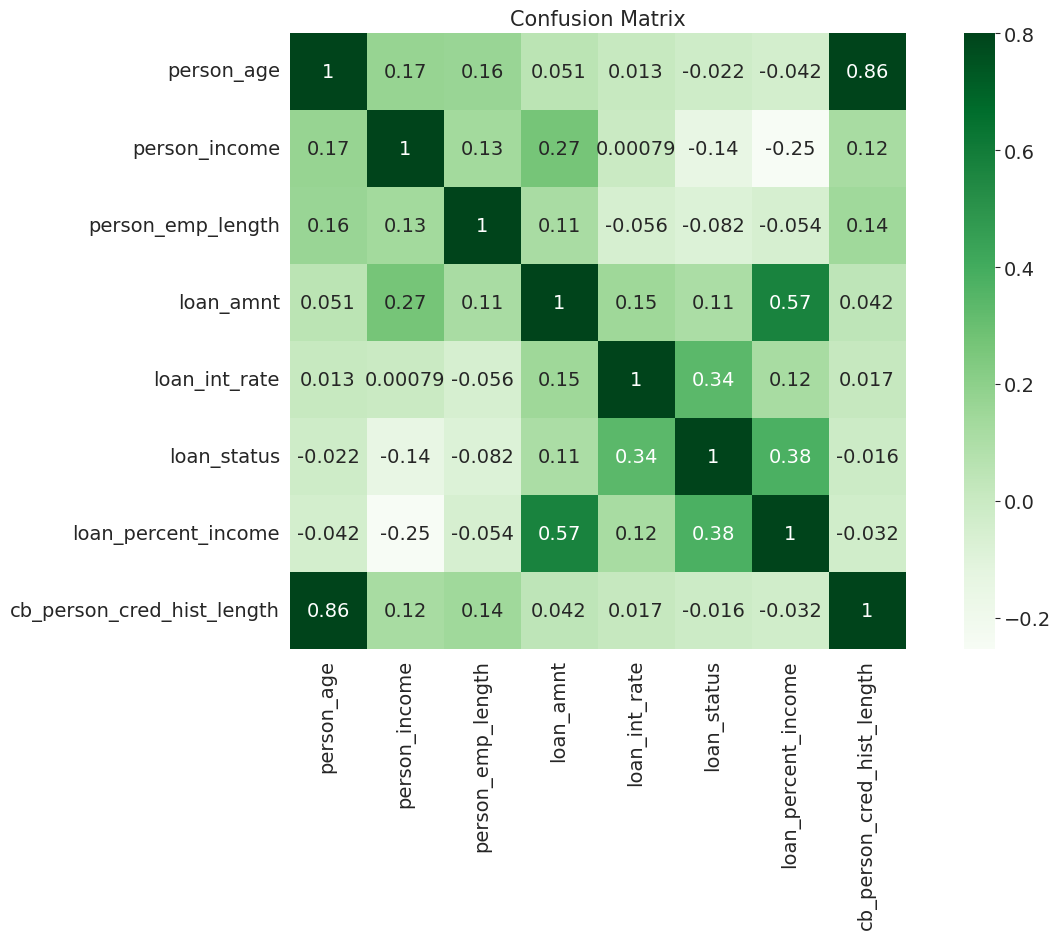

In [13]:
fig, ax = plt.subplots() 
fig.set_size_inches(15,8)
sns.heatmap(data_copy.corr(), vmax =.8, square = True, annot = True,cmap='Greens' )
plt.title('Confusion Matrix',fontsize=15);

### Correlation Matrix Summary  
- **Strong Positive Correlations:**  
  - **Age and Credit History Length (0.86):** Older individuals tend to have longer credit histories.  
  - **Loan Amount and Loan Percent Income (0.57):** Higher loan amounts are associated with a greater percentage of income being allocated to the loan.  

- **Moderate Positive Correlations:**  
  - **Income and Loan Amount (0.27):** Higher income is linked to higher loan amounts.  
  - **Loan Interest Rate and Loan Status (0.34):** A higher interest rate appears to be associated with loan status, potentially indicating riskier loans.  

- **Weak or Negligible Correlations:**  
  - Loan interest rate has little correlation with most variables, except for a moderate connection with loan status.  
  - Employment length has weak correlations with all features, suggesting it might not be a strong predictor of loan-related outcomes.  

- **Negative Correlations:**  
  - **Income and Loan Percent Income (-0.25):** Higher-income individuals tend to allocate a smaller proportion of their income to loan payments.  

## Univarient  Analysis

Univariate analysis is the examination of a single variable in a dataset. It focuses on summarizing and understanding the distribution, central tendency (mean, median, mode), spread (variance, standard deviation), and outliers of individual variables.

In [14]:
#max and min income
max_ = data['person_income'].max()
min_ = data['person_income'].min()

print(f"maximum Income {max_}")
print(f"minimum Income {min_}")

#people with an income between x and y
def income_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = data['person_income'].between(next,arr[i+1]).sum()
        print(f'Income between {next} and {arr[i+1]}: Number of people {num_people}')
        
income_group([0, 25000, 50000, 75000, 100000,float('inf')])

maximum Income 6000000
minimum Income 4000
Income between 1 and 25000: Number of people 2469
Income between 25001 and 50000: Number of people 11613
Income between 50001 and 75000: Number of people 9622
Income between 75001 and 100000: Number of people 4670
Income between 100001 and inf: Number of people 4207


In [15]:
#MAX AND MIN AGE
max_ = data['person_age'].max()
min_ = data['person_age'].min()
print(f"maximum Age {max_}")
print(f"minimum Age {min_}")

# people with an age between x and y
def age_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = data['person_age'].between(next,arr[i+1]).sum()
        print(f'Age between {next} and {arr[i+1]}: Number of people {num_people}')
        
age_group([0 ,18, 26, 36, 46, 56, 66])

maximum Age 144
minimum Age 20
Age between 1 and 18: Number of people 0
Age between 19 and 26: Number of people 17829
Age between 27 and 36: Number of people 11834
Age between 37 and 46: Number of people 2360
Age between 47 and 56: Number of people 434
Age between 57 and 66: Number of people 98


In [16]:
#min and max loan amount
max_loan_amount = data['loan_amnt'].max()
min_loan_amount = data['loan_amnt'].min()

print(f"maximum Loan Amount {max_loan_amount}")
print(f"minimum Loan Amount {min_loan_amount}")

# people with an income between x and y
def loan_amount_group(arr):
    lenarr = len(arr)
    for i in range(0,lenarr-1):
        next = arr[i]+1
        num_people = data['loan_amnt'].between(next,arr[i+1]).sum()
        print(f'Loan Amount between {next} and {arr[i+1]}: Number of people {num_people}')
        
loan_amount_group([0, 5000, 10000, 15000, float('inf')])

maximum Loan Amount 35000
minimum Loan Amount 500
Loan Amount between 1 and 5000: Number of people 9489
Loan Amount between 5001 and 10000: Number of people 12040
Loan Amount between 10001 and 15000: Number of people 6123
Loan Amount between 15001 and inf: Number of people 4929


In [17]:
level_counts=data.person_home_ownership.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          title= 'person_home_ownership'
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=13,
                  marker=dict(line=dict(color='#102000', width=0.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

In [18]:
level_counts=data.loan_grade.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          title= 'loan_grade'
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=13,
                  marker=dict(line=dict(color='#102000', width=0.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

In [19]:
fig=px.histogram(data, x = 'loan_intent',histnorm = 'percent', text_auto = '.2f',template = 'presentation', title = 'loan intent',color_discrete_sequence=px.colors.sequential.Mint)
fig.update_layout()
fig.show()

In [20]:
fig=px.histogram(data, x = 'cb_person_cred_hist_length', text_auto = '.2f',template = 'presentation', title = 'person credit history length',color_discrete_sequence=px.colors.sequential.Mint)
fig.update_layout()
fig.show()

The charts provide insights into key categorical and numerical features in the loan dataset. Homeownership is dominated by renters (50.5%), followed by mortgage holders (41.3%), while only a small portion owns their homes. Loan grades are primarily distributed across A (33.1%), B (32.1%), and C (19.8%), with lower representation in grades D through G. Loan intent varies, with education (19.8%), medical (18.6%), and personal (16.9%) being the most common reasons for borrowing. Credit history length is skewed, with most individuals having a short credit history, concentrated around the lower end of the scale. These distributions highlight key borrower characteristics that could impact loan decisions.

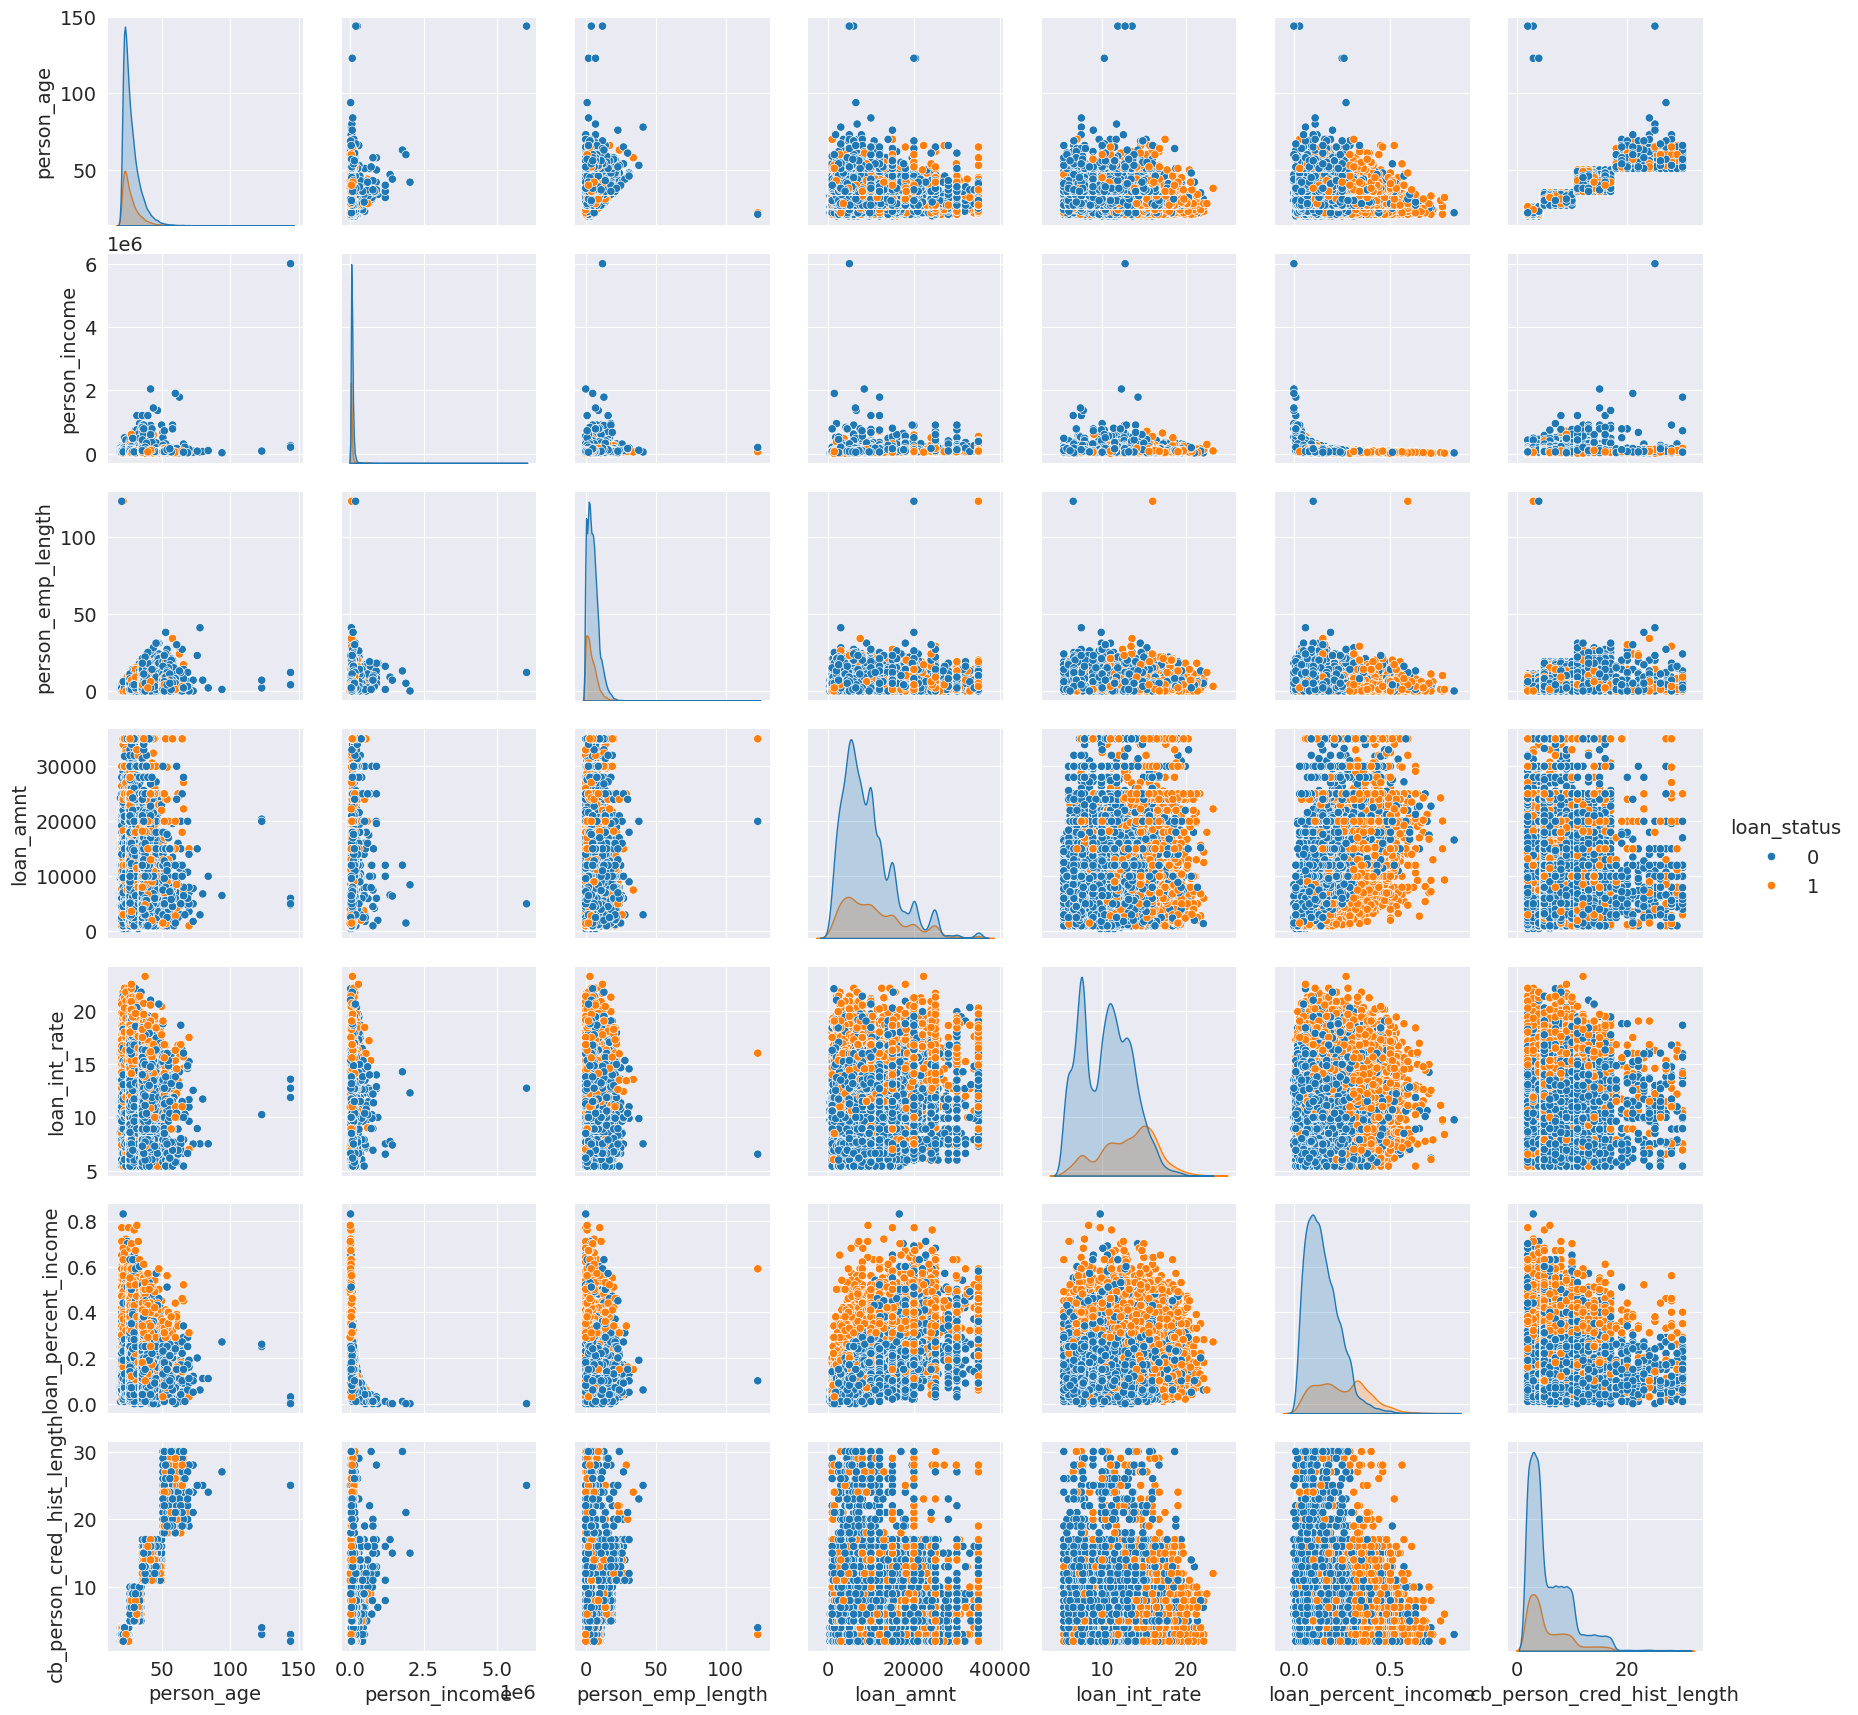

In [21]:
sns.pairplot(data,hue="loan_status")

The pair plot visualizes relationships between numerical variables in the loan dataset, distinguishing loan statuses (0 and 1) with color coding. The diagonal plots show the distribution of individual variables, highlighting skewness in age, income, and loan amount. Scatter plots reveal weak correlations, with loan amount and income showing some positive association. Outliers are present, particularly in income and age. Loan status does not show strong separability across most features, suggesting complex relationships that may require further feature engineering or advanced modeling techniques.

## Feature Engineering

### Dealing with outliers

Handling outliers before building a model is crucial because extreme values can distort statistical relationships and lead to biased or unstable predictions. Outliers can disproportionately affect models like linear regression by skewing coefficients or influencing decision boundaries in classification models. By detecting and addressing outliers—through removal, transformation, or capping—we improve model accuracy, robustness, and generalizability to new data.

In [22]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Dropping null values is necessary to prevent errors and inconsistencies in model training and analysis. Many machine learning algorithms cannot handle missing data, leading to inaccurate predictions or failed computations. Removing null values ensures a cleaner dataset, improves model performance, and prevents biases that could arise from incomplete information.

In [23]:
# drop values that are null
data.dropna(axis=0,inplace=True)

In [24]:
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [25]:
#person_age max 144 (issue)
#person_emp_length max 123 (issue)
data.reset_index(inplace = True)

### Age Groups

Grouping ages in loan data using defined bins helps uncover patterns in borrowing behavior, loan approvals, and default risks across different age ranges. For example, segmenting borrowers into groups like **20-25, 26-35, 36-45, 46-55, and 56-65** allows us to analyze how financial stability, credit history, and loan repayment tendencies vary by age. Younger borrowers (20-25) may have limited credit history and lower incomes, leading to higher loan rejection rates or higher interest rates, while those in the **26-35 and 36-45** age groups might have more stable incomes and better credit scores, improving their chances of loan approval. Older borrowers (46-55 and 56-65) may have stronger credit histories but different debt-to-income considerations. By categorizing age, we enhance model interpretability, reduce noise, and capture meaningful insights that help in risk assessment and lending decisions.

<BarContainer object of 57 artists>

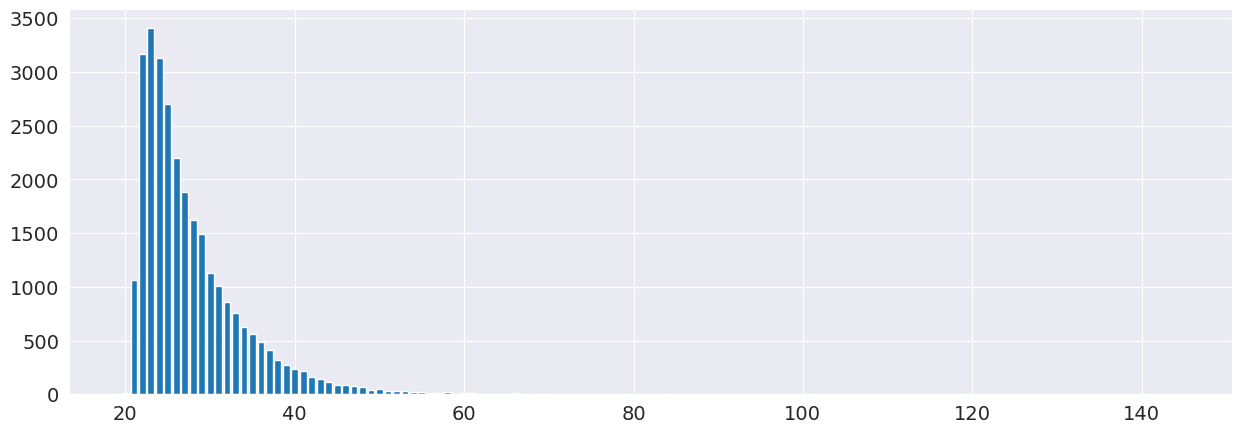

In [26]:
import matplotlib.pyplot as plt 
verti = data['person_age'].value_counts().values
hori = data['person_age'].value_counts().index
fig = plt.figure(figsize = (15, 5))
plt.bar(hori, verti)

In [27]:
(data['person_age'].value_counts().values>90).sum()

25

In [28]:
data = data.drop(data[data['person_age'] > 80].index, axis=0)
#dropping age above 80

In [29]:
data['age_group'] = pd.cut(data['person_age'],
                           bins=[20, 26, 36, 46, 56, 66],
                           labels=['20-25', '26-35', '36-45', '46-55', '56-65'])

In [30]:
data['age_group'].dtype

CategoricalDtype(categories=['20-25', '26-35', '36-45', '46-55', '56-65'], ordered=True, categories_dtype=object)

### Income Groups

Creating income groups in loan data helps analyze borrowing behavior, loan approval rates, and default risk across different financial brackets. By segmenting income into five categories—low (<25,000),low-middle (25,000-50,000), middle (50,000-75,000), high-middle (75,000-100,000), and high (>$100,000)—we can identify trends in loan repayment and lending risk. Lower-income borrowers may have higher debt-to-income ratios and face stricter lending criteria, while middle and high-income groups typically secure better loan terms and lower default risk. This structured grouping helps improve model interpretability, mitigates the impact of extreme income values, and allows for better feature engineering by capturing non-linear relationships between income and loan outcomes.

In [31]:
data['income_group'] = pd.cut(data['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

In [32]:
data['income_group']

0             middle
1                low
2                low
3             middle
4             middle
            ...     
28633         middle
28634           high
28635    high-middle
28636           high
28637     low-middle
Name: income_group, Length: 28633, dtype: category
Categories (5, object): ['low' < 'low-middle' < 'middle' < 'high-middle' < 'high']

### Loan Amount

Categorizing loan amounts into **small (≤5,000), medium (5,001-10,000), large (10,001-15,000), and very large (>15,000)** helps identify trends in loan approvals, default rates, and interest rate distributions across different loan sizes. Smaller loans are more common among lower-income borrowers or those with limited credit history, while very large loans are typically associated with higher-income individuals or riskier lending decisions. Grouping loan amounts simplifies feature relationships, reduces noise, and enhances interpretability by capturing non-linear patterns that raw numerical values might obscure. This approach also allows lenders to tailor risk management strategies and lending criteria for different loan categories.

In [33]:
data['loan_amount_group'] = pd.cut(data['loan_amnt'],
                                   bins=[0, 5000, 10000, 15000, float('inf')],
                                   labels=['small', 'medium', 'large', 'very large'])

In [34]:
data['loan_amount_group']

0        very large
1             small
2            medium
3        very large
4        very large
            ...    
28633        medium
28634    very large
28635    very large
28636         large
28637        medium
Name: loan_amount_group, Length: 28633, dtype: category
Categories (4, object): ['small' < 'medium' < 'large' < 'very large']

In [35]:
data = data.drop(data[data['person_emp_length'] > 60].index, axis=0)

In [36]:
data = data.drop(['index'], axis=1)
data.reset_index(inplace = True)
data = data.drop(['index'], axis=1)

In [37]:
data['person_home_ownership'].value_counts()

person_home_ownership
RENT        14548
MORTGAGE    11797
OWN          2192
OTHER          94
Name: count, dtype: int64

### Financial Ratios

Creating **loan-to-income ratio, loan-to-employment length ratio, and interest rate-to-loan amount ratio** provides key insights into borrowing behavior and loan risk assessment. **Loan-to-income ratio** measures a borrower's debt burden relative to their income, where higher values indicate increased financial strain and potential default risk. **Loan-to-employment length ratio** evaluates financial stability by comparing employment duration to the loan amount, helping assess repayment ability. **Interest rate-to-loan amount ratio** highlights how interest rates vary with loan sizes, identifying whether larger loans are associated with higher risk and interest rates. These engineered features enhance model performance by capturing meaningful financial relationships that raw data may not fully express.

In [38]:
# Create loan-to-income ratio
data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

# Create loan-to-employment length ratio
data['loan_to_emp_length_ratio'] =  data['person_emp_length']/ data['loan_amnt'] 

# Create interest rate-to-loan amount ratio
data['int_rate_to_loan_amt_ratio'] = data['loan_int_rate'] / data['loan_amnt']

In [39]:
data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_group',
       'income_group', 'loan_amount_group', 'loan_to_income_ratio',
       'loan_to_emp_length_ratio', 'int_rate_to_loan_amt_ratio'],
      dtype='object')

### A couple of steps to prepare columns for preprocessing

In [40]:
raw_data = data.copy()

In [41]:
#Organize Columns
col_list = ['person_age',#
 'person_income',#
 'person_home_ownership',#
 'person_emp_length',#
 'loan_intent', #
 'loan_grade',#
 'loan_amnt',#
 'loan_int_rate',#
 'loan_status',#
 'loan_percent_income',#
 'cb_person_default_on_file',#
 'cb_person_cred_hist_length',
'age_group','income_group','loan_amount_group']

drop_colums = []
scale_cols = ['person_income','person_age','person_emp_length', 'loan_amnt','loan_int_rate','cb_person_cred_hist_length','loan_percent_income','loan_to_income_ratio', 'loan_to_emp_length_ratio',
       'int_rate_to_loan_amt_ratio']
ohe_colums = ['cb_person_default_on_file','loan_grade', 'person_home_ownership','loan_intent','income_group','age_group','loan_amount_group']
le_colums = []

In [42]:
data = data.drop(drop_colums, axis=1)

In [43]:
data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_group',
       'income_group', 'loan_amount_group', 'loan_to_income_ratio',
       'loan_to_emp_length_ratio', 'int_rate_to_loan_amt_ratio'],
      dtype='object')

## Data Preprocessing

In [44]:
# Separating Features (X) and Target Variable (Y)

# X: Creating the feature matrix by dropping the target variable ('loan_status')
X = data.drop(['loan_status'], axis=1)  # All independent variables used for prediction

# Y: Defining the target variable (loan_status), which represents whether a loan is approved or defaulted
Y = data['loan_status']  # Dependent variable (label) for model training

Spit Data into traing data and test data

In [45]:
# Importing train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X,  # Feature matrix
    Y,  # Target variable (loan_status)
    test_size=0.2,  # 20% of the data is allocated for testing, 80% for training
    random_state=12  # Ensures reproducibility by setting a fixed random seed
)

In [46]:
print(x_train.shape,x_test.shape)

(22904, 17) (5727, 17)


In [47]:
# Resetting the index of the training and testing feature datasets
x_train.reset_index(inplace=True)  # Ensures the index starts from 0 after splitting
x_test.reset_index(inplace=True)   # Avoids misalignment issues when processing data

# This is useful because train_test_split retains the original dataset's indices,
# and resetting the index ensures a clean, sequential order for further operations.

In [48]:
x_train.columns

Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'age_group', 'income_group',
       'loan_amount_group', 'loan_to_income_ratio', 'loan_to_emp_length_ratio',
       'int_rate_to_loan_amt_ratio'],
      dtype='object')

This code initializes a **OneHotEncoder**, which converts categorical variables into a numerical format for machine learning models. It fits the encoder to the specified categorical columns in the training dataset, learning the unique categories in each column. This ensures that categorical data is transformed into a binary matrix, where each category is represented by a separate column with `0` or `1` values, making it suitable for model training.

In [49]:
# Importing OneHotEncoder from scikit-learn for categorical feature encoding
from sklearn.preprocessing import OneHotEncoder

# Creating an instance of OneHotEncoder
ohe = OneHotEncoder()

# Fitting the encoder to the categorical columns in the training data
ohe.fit(x_train[ohe_colums])  # Learns the unique categories for one-hot encoding

OneHotEncoder()

In [50]:
ohe.categories_

[array(['N', 'Y'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object),
 array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object),
 array(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
        'PERSONAL', 'VENTURE'], dtype=object),
 array(['high', 'high-middle', 'low', 'low-middle', 'middle'], dtype=object),
 array(['20-25', '26-35', '36-45', '46-55', '56-65', nan], dtype=object),
 array(['large', 'medium', 'small', 'very large'], dtype=object)]

This code extracts the unique categories learned by the **OneHotEncoder** and merges them into a single NumPy array. Each `ohe.categories_[i]` represents the distinct categories from a specific categorical column. Using `np.concatenate()`, these categories are combined into one array, allowing for easier tracking of the transformed feature names. This step is useful for aligning encoded data with its corresponding categories when analyzing or interpreting the results.

In [51]:
# Merging the unique categories learned by OneHotEncoder into a single array
merge_ohe_col = np.concatenate((
    ohe.categories_[0],  # Categories from the first categorical column
    ohe.categories_[1],  # Categories from the second categorical column
    ohe.categories_[2],  # Categories from the third categorical column
    ohe.categories_[3],  # Categories from the fourth categorical column
    ohe.categories_[4],  # Categories from the fifth categorical column
    ohe.categories_[5],  # Categories from the sixth categorical column
    ohe.categories_[6]   # Categories from the seventh categorical column
))

In [52]:
merge_ohe_col

array(['N', 'Y', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'MORTGAGE', 'OTHER',
       'OWN', 'RENT', 'DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT',
       'MEDICAL', 'PERSONAL', 'VENTURE', 'high', 'high-middle', 'low',
       'low-middle', 'middle', '20-25', '26-35', '36-45', '46-55',
       '56-65', nan, 'large', 'medium', 'small', 'very large'],
      dtype=object)

In [53]:
# Transforming categorical features in the training set using OneHotEncoder
# Converts the encoded data into a DataFrame with appropriate column names
ohe_data = pd.DataFrame(
    ohe.transform(x_train[ohe_colums]).toarray(),  # Applies OHE transformation and converts to an array
    columns=merge_ohe_col  # Assigns meaningful column names using merged category names
)

# Transforming categorical features in the testing set using OneHotEncoder
# Converts the encoded data into a DataFrame with appropriate column names
ohe_data2 = pd.DataFrame(
    ohe.transform(x_test[ohe_colums]).toarray(),  # Applies OHE transformation to test data
    columns=merge_ohe_col  # Assigns column names to match the training set
)

In [54]:
# Merging the one-hot encoded categorical features with the original training data
X_new = pd.concat([ohe_data, x_train], axis=1)  # Combines encoded data with the training dataset
X_new = X_new.drop(ohe_colums, axis=1)  # Removes the original categorical columns since they are now encoded

# Merging the one-hot encoded categorical features with the original testing data
X_new_test = pd.concat([ohe_data2, x_test], axis=1)  # Combines encoded data with the test dataset
X_new_test = X_new_test.drop(ohe_colums, axis=1)  # Removes the original categorical columns from the test set

In [55]:
X_new.head()

N    Y    A    B    C    D    E    F    G  MORTGAGE  ...  person_age  \
0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0       1.0  ...          23   
1  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0       1.0  ...          44   
2  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0       1.0  ...          25   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0       1.0  ...          34   
4  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0       1.0  ...          23   

   person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          66000                5.0       6000           6.62   
1          95000                4.0      10000          10.95   
2          32004                3.0      22750           6.17   
3          90000               19.0       5000          13.61   
4          50000                6.0       7000           5.99   

   loan_percent_income  cb_person_cred_hist_length  loan_to_income_ratio  \
0                 0.09                           2              0.090909   
1                 0.11                          15              0.105263   
2                 0.71                           4              0.710849   
3                 0.06                           8              0.055556   
4                 0.14                           3              0.140000   

   loan_to_emp_length_ratio  int_rate_to_loan_amt_ratio  
0                  0.000833                    0.001103  
1                  0.000400                    0.001095  
2                  0.000132                    0.000271  
3                  0.003800                    0.002722  
4                  0.000857                    0.000856  

[5 rows x 45 columns]

In [56]:
X_new.shape

(22904, 45)

In [57]:
X_new_test.head()

N    Y    A    B    C    D    E    F    G  MORTGAGE  ...  person_age  \
0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0       1.0  ...          35   
1  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0       0.0  ...          35   
2  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0       0.0  ...          32   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0       0.0  ...          25   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0       0.0  ...          32   

   person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          66000                4.0       3000           6.03   
1          33144                3.0       8400          14.91   
2          36000                4.0       6000          16.07   
3          61500                1.0      18000          13.23   
4          24000                7.0       2800          10.99   

   loan_percent_income  cb_person_cred_hist_length  loan_to_income_ratio  \
0                 0.05                           7              0.045455   
1                 0.25                           8              0.253440   
2                 0.17                          10              0.166667   
3                 0.29                           2              0.292683   
4                 0.12                           9              0.116667   

   loan_to_emp_length_ratio  int_rate_to_loan_amt_ratio  
0                  0.001333                    0.002010  
1                  0.000357                    0.001775  
2                  0.000667                    0.002678  
3                  0.000056                    0.000735  
4                  0.002500                    0.003925  

[5 rows x 45 columns]

In [58]:
# Importing different scalers from scikit-learn for feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Defining the columns that need to be scaled
scale_cols = ['person_income', 'person_age', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
              'cb_person_cred_hist_length', 'loan_percent_income', 'loan_to_emp_length_ratio',
              'int_rate_to_loan_amt_ratio']

# Placeholder lists for different types of scaling methods
uniform_col = []  # Intended for MinMax scaling (not used in current code)
normal_col = scale_cols  # Features that will be scaled using StandardScaler
bimodal_col = []  # Intended for Robust scaling (not used in current code)

# Initializing different scalers for various types of distributions
scaler_uniform = MinMaxScaler()  # Scales data to a range of [0,1]

# Applying MinMaxScaler if there are any uniform distribution columns (currently commented out)
# X_new.loc[:, uniform_col] = scaler_uniform.fit_transform(X_new.loc[:, uniform_col])
# X_new_test.loc[:, uniform_col] = scaler_uniform.transform(X_new_test.loc[:, uniform_col])

scaler_normal = StandardScaler()  # Standardizes data by centering it to mean=0 and variance=1

# Applying StandardScaler to normally distributed columns
X_new.loc[:, normal_col] = scaler_normal.fit_transform(X_new.loc[:, normal_col])  # Fit & transform training data
X_new_test.loc[:, normal_col] = scaler_normal.transform(X_new_test.loc[:, normal_col])  # Transform test data

scaler_bimodal = RobustScaler()  # Uses median and IQR for scaling, useful for handling outliers

# Applying RobustScaler if there are any bimodal distribution columns (currently commented out)
# X_new.loc[:, bimodal_col] = scaler_bimodal.fit_transform(X_new.loc[:, bimodal_col])
# X_new_test.loc[:, bimodal_col] = scaler_bimodal.transform(X_new_test.loc[:, bimodal_col])

In [59]:
X_new_test.head()

N    Y    A    B    C    D    E    F    G  MORTGAGE  ...  person_age  \
0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0       1.0  ...    1.181707   
1  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0       0.0  ...    1.181707   
2  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0       0.0  ...    0.695186   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0       0.0  ...   -0.440030   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0       0.0  ...    0.695186   

   person_income  person_emp_length  loan_amnt  loan_int_rate  \
0      -0.006231          -0.192831  -1.052710      -1.556377   
1      -0.655354          -0.440648  -0.197407       1.195223   
2      -0.598929          -0.192831  -0.577541       1.554667   
3      -0.095136          -0.936282   1.323133       0.674650   
4      -0.836009           0.550621  -1.084388      -0.019447   

   loan_percent_income  cb_person_cred_hist_length  loan_to_income_ratio  \
0            -1.123388                    0.296643              0.045455   
1             0.757473                    0.543970              0.253440   
2             0.005128                    1.038624              0.166667   
3             1.133645                   -0.939991              0.292683   
4            -0.465087                    0.791297              0.116667   

   loan_to_emp_length_ratio  int_rate_to_loan_amt_ratio  
0                  0.530868                    0.076675  
1                 -0.380924                   -0.049526  
2                 -0.091820                    0.435586  
3                 -0.662616                   -0.608033  
4                  1.620571                    1.105078  

[5 rows x 45 columns]

## Train Classifiers

### Installing Necessary Packages

In [60]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install optunahub

Note: you may need to restart the kernel to use updated packages.


In [62]:
# Importing machine learning models from scikit-learn and other libraries

# Linear Models
from sklearn.linear_model import LinearRegression  # Linear regression model for continuous target prediction
from sklearn.linear_model import LogisticRegression  # Logistic regression for binary classification

# Support Vector Machine (SVM)
from sklearn.svm import SVC  # Support Vector Classifier for binary/multi-class classification

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes, often used for text classification

# Decision Trees and Nearest Neighbors
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier for non-linear relationships
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors (KNN) classifier for proximity-based classification

# Ensemble Models (Bagging & Boosting)
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier using multiple decision trees
from sklearn.ensemble import AdaBoostClassifier  # Adaptive Boosting classifier for ensemble learning
from sklearn.ensemble import BaggingClassifier  # Bagging classifier for reducing variance in models
from sklearn.ensemble import ExtraTreesClassifier  # Extra Trees classifier, a variation of Random Forest with randomized splits
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting classifier for iterative model training

# XGBoost (Extreme Gradient Boosting)
from xgboost import XGBClassifier  # XGBoost classifier, optimized for speed and performance

# CatBoost (Categorical Boosting)
from catboost import CatBoostClassifier  # CatBoost classifier, efficient for categorical data

# LightGBM (Light Gradient Boosting Machine)
import lightgbm as lgb  # LightGBM library for efficient gradient boosting
from lightgbm import LGBMClassifier  # LightGBM classifier, optimized for speed and accuracy
from lightgbm import LGBMRegressor  # LightGBM regressor for continuous target predictions

# Evaluation Metrics
from sklearn.metrics import make_scorer, mean_absolute_error  # Custom scoring functions and MAE metric
from sklearn.metrics import mean_squared_error as MSE  # Mean Squared Error (MSE) metric

# Hyperparameter Optimization
from optuna import *  # Optuna library for automated hyperparameter tuning

# Model Selection & Cross-Validation
from sklearn.model_selection import GridSearchCV  # Grid search for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold  # Stratified K-Fold cross-validation for imbalanced datasets
from sklearn.model_selection import KFold, cross_val_score  # K-Fold cross-validation and model scoring

This code **initializes a diverse set of machine learning classifiers**, ranging from **traditional algorithms** (e.g., Logistic Regression, Decision Trees) to **ensemble-based models** (e.g., Random Forest, XGBoost, LightGBM) and **boosting techniques** (e.g., AdaBoost, Gradient Boosting). These models vary in complexity and effectiveness across different types of datasets:  

- **Simple models** like Logistic Regression and Naive Bayes provide **baseline performance** for classification.  
- **Tree-based models** (Decision Tree, Random Forest, Extra Trees) are **interpretable and handle non-linearity well**.  
- **Ensemble methods** (Bagging, Boosting, XGBoost, CatBoost, LightGBM) enhance **model accuracy and robustness**.  
- **SVM and k-NN** work well for **high-dimensional and structured data**, respectively.  

By initializing multiple models, this approach allows for **comparative evaluation** to determine the best-performing classifier for a given dataset.

In [63]:
# Initializing various machine learning models for classification

# Support Vector Machine (SVM) classifier
svc = SVC()  # Uses hyperplanes to separate classes, effective for high-dimensional data

# k-Nearest Neighbors (KNN) classifier
knc = KNeighborsClassifier()  # Classifies based on the nearest neighbors in feature space

# Naive Bayes classifier (Multinomial Naive Bayes)
mnb = MultinomialNB()  # Probabilistic classifier best suited for text and categorical data

# Decision Tree classifier
dtc = DecisionTreeClassifier()  # Splits data into decision nodes for classification

# Logistic Regression classifier
lrc = LogisticRegression()  # Linear model for binary/multi-class classification, outputs probability scores

# Random Forest classifier
rfc = RandomForestClassifier()  # Ensemble model that builds multiple decision trees and averages results

# AdaBoost classifier (Adaptive Boosting)
abc = AdaBoostClassifier()  # Sequentially trains weak models and adjusts weights to improve performance

# Bagging classifier
bc = BaggingClassifier()  # Uses bootstrap aggregation to reduce variance and improve stability

# Extra Trees classifier
etc = ExtraTreesClassifier()  # Similar to Random Forest but uses more randomness in feature splits

# Gradient Boosting Decision Trees (GBDT) classifier
gbdt = GradientBoostingClassifier()  # Sequentially builds trees to correct errors from previous trees

# XGBoost classifier
xgb = XGBClassifier()  # Optimized implementation of gradient boosting with better performance

# CatBoost classifier
cat = CatBoostClassifier(verbose=0)  # Boosting algorithm optimized for categorical features, silenced output

# LightGBM (Light Gradient Boosting Machine) classifier
lgb = lgb.LGBMClassifier()  # Gradient boosting model optimized for speed and efficiency

The selected models in this dictionary represent a **balanced mix of traditional and advanced machine learning algorithms**, chosen for their distinct strengths in classification tasks:  

- **k-Nearest Neighbors (KNN)** is included as a **baseline distance-based model**, which is simple yet effective for small to medium-sized datasets with well-defined patterns.  
- **XGBoost (XGB)** is a **highly optimized gradient boosting algorithm**, known for its **speed, scalability, and superior predictive performance**, making it ideal for complex datasets.  
- **CatBoost (CAT)** is selected for its ability to **handle categorical variables natively**, reducing preprocessing overhead while improving accuracy.  
- **LightGBM (LGB)** is chosen for its **efficient training on large datasets**, leveraging histogram-based feature selection to significantly reduce memory usage and computation time.  

By including **both traditional and advanced gradient boosting models**, this selection ensures that we evaluate a mix of **interpretability, efficiency, and predictive power**, ultimately allowing us to find the best-performing classifier for our dataset. 

In [64]:
# Creating a dictionary of selected classification models for training and evaluation
clf = {
    'KN' : knc,   # k-Nearest Neighbors (KNN) - A distance-based classifier that works well with smaller datasets
    'xgb': xgb,   # XGBoost - A high-performance gradient boosting model, optimized for speed and accuracy
    'cat': cat,   # CatBoost - A gradient boosting model specialized for handling categorical features efficiently
    'lgb': lgb    # LightGBM - A fast, efficient gradient boosting model for large datasets
}

The following function **trains and evaluates a classification model** using multiple performance metrics and visualizations. It fits the model to the training data, makes predictions on the test set, and leverages custom functions to calculate and display key metrics, including **accuracy, precision, recall, AUC score, and specificity**. The function also generates a **confusion matrix** for assessing classification performance and plots an **ROC curve** to visualize the trade-off between true positive and false positive rates. By structuring the evaluation process with modular functions, the code ensures a comprehensive and standardized approach to assessing model performance.

In [65]:
# Importing required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Function to train and evaluate a classifier with integrated custom functions
def train_classifier(clf, X_train, y_train, X_test, y_test):
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)  # Get probabilities for ROC curve calculation

    # Use the custom function to calculate all relevant metrics
    calculateMetricsAndPrint(y_pred, y_pred_prob, y_test)

    # Plot confusion matrix using the custom function
    plot_conf_mat(clf, X_test, y_test)

    # Plot ROC Curve using the custom function
    plot_roc_curve(y_test, [item[1] for item in y_pred_prob])

    # Return predictions for further analysis if needed
    return y_pred

This function **trains and evaluates a classification model** using multiple performance metrics and visualizations. It fits the model to the training data, makes predictions on the test set, and leverages custom functions to calculate and display key metrics, including **accuracy, precision, recall, AUC score, and specificity**. The function also generates a **confusion matrix** for assessing classification performance and plots an **ROC curve** to visualize the trade-off between true positive and false positive rates. By structuring the evaluation process with modular functions, the code ensures a comprehensive and standardized approach to assessing model performance.

In [66]:
# Dropping columns with NaN (missing) values in the training dataset
X_new = X_new.drop(
    columns=[col for col in X_new.columns if pd.isna(col)],  # Identifies columns with NaN values
    axis=1  # Specifies that columns (not rows) should be removed
)

# Dropping columns with NaN (missing) values in the test dataset
X_new_test = X_new_test.drop(
    columns=[col for col in X_new_test.columns if pd.isna(col)],  # Identifies columns with NaN values
    axis=1  # Specifies column removal
)

In [100]:
!pip install tabulate


🔹 Training KN Model...

Accuracy: 79.43
PrecisionNegative: 82.13
PrecisionPositive: 55.65
RecallNegative: 94.22
RecallPositive: 26.13
AUC Score: 64.95



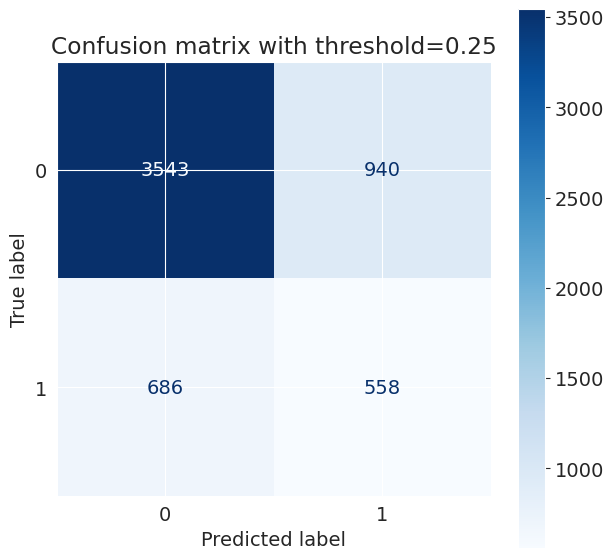

AUC Score = 64.952


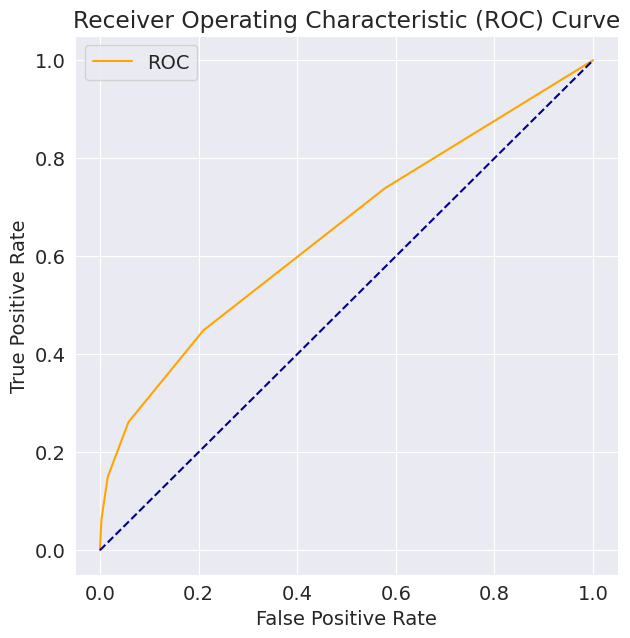

KN model completed.


🔹 Training xgb Model...

Accuracy: 94.27
PrecisionNegative: 93.65
PrecisionPositive: 97.31
RecallNegative: 99.42
RecallPositive: 75.72
AUC Score: 96.36



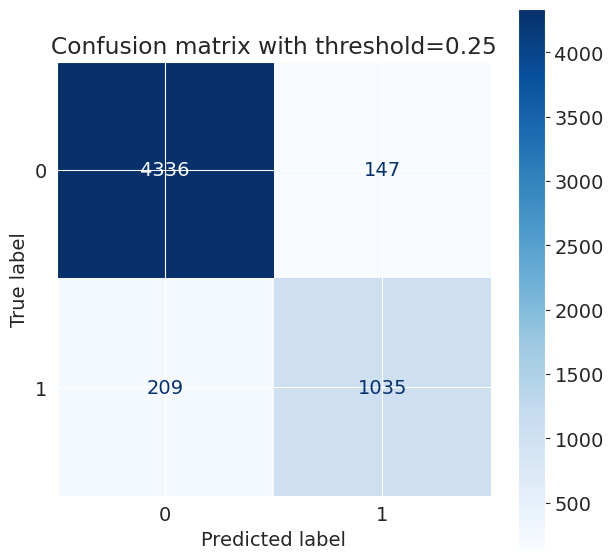

AUC Score = 96.358


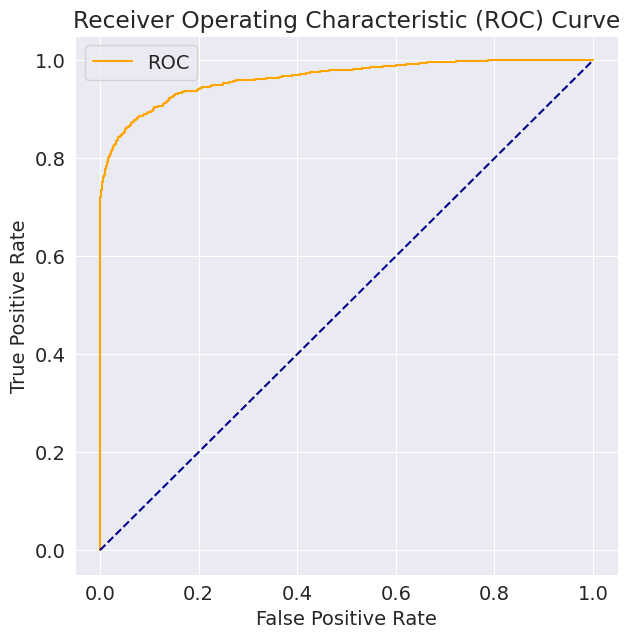

xgb model completed.


🔹 Training cat Model...

Accuracy: 94.33
PrecisionNegative: 93.49
PrecisionPositive: 98.52
RecallNegative: 99.69
RecallPositive: 75.00
AUC Score: 96.65



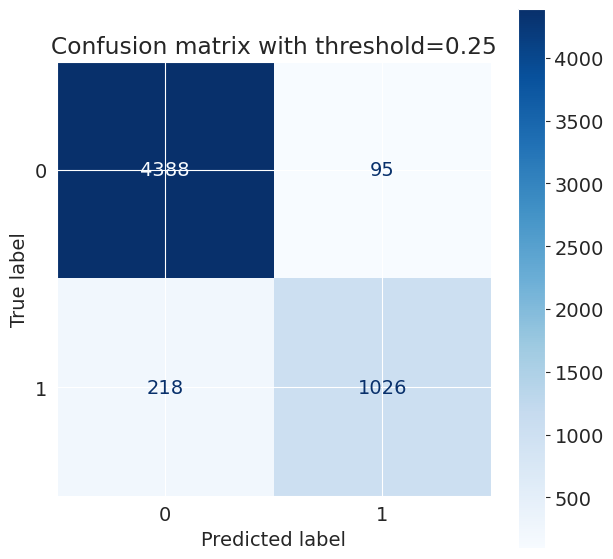

AUC Score = 96.651


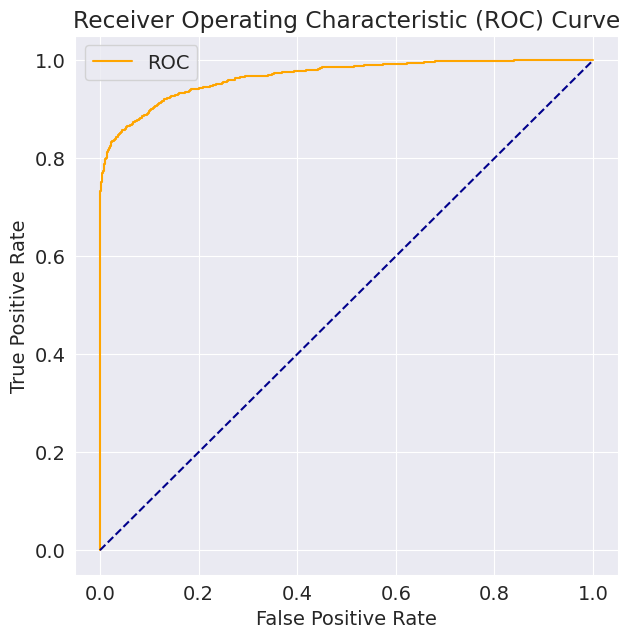

cat model completed.


🔹 Training lgb Model...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4958, number of negative: 17946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 22904, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216469 -> initscore=-1.286365
[LightGBM] [Info] Start training from score -1.286365
Accuracy: 93.91
PrecisionNegative: 92.99
PrecisionPositive: 98.69
RecallNegative: 99.73
RecallPositive: 72.91
AUC Score: 95.89



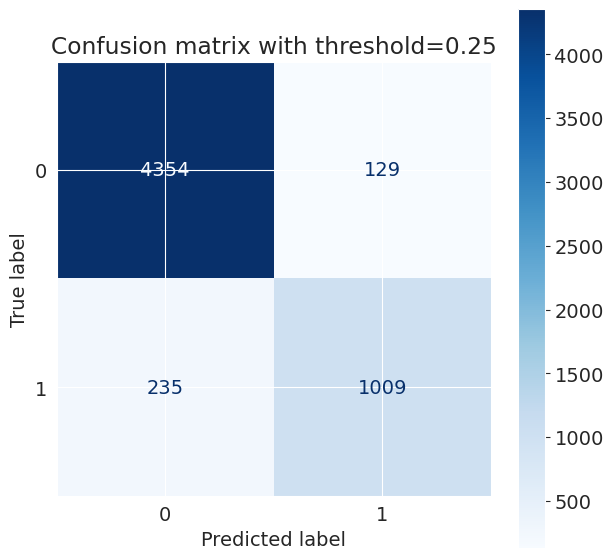

AUC Score = 95.890


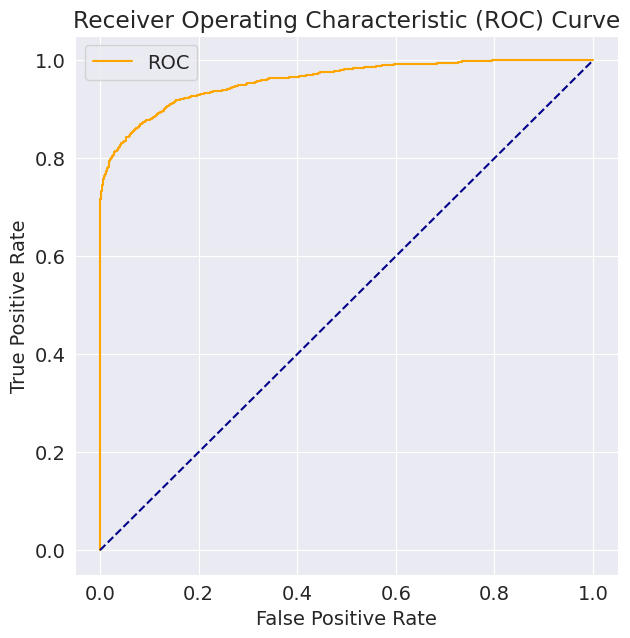

lgb model completed.


📊 **Model Performance Summary** 📊

╒═════════╤════════════╤═════════════╤══════════╤═══════════════╕
│ Model   │   Accuracy │   Precision │   Recall │   Specificity │
╞═════════╪════════════╪═════════════╪══════════╪═══════════════╡
│ KN      │     0.7943 │      0.5565 │   0.2613 │        0.9422 │
├─────────┼────────────┼─────────────┼──────────┼───────────────┤
│ xgb     │     0.9427 │      0.9731 │   0.7572 │        0.9942 │
├─────────┼────────────┼─────────────┼──────────┼───────────────┤
│ cat     │     0.9433 │      0.9852 │   0.75   │        0.9969 │
├─────────┼────────────┼─────────────┼──────────┼───────────────┤
│ lgb     │     0.9391 │      0.9869 │   0.7291 │        0.9973 │
╘═════════╧════════════╧═════════════╧══════════╧═══════════════╛


In [101]:
# Import the `tabulate` library to format results in a table
from tabulate import tabulate

# Initialize an empty list to store performance metrics for different models
results = []

# Loop through each classifier in the dictionary `clf`, train it, and evaluate performance
for name, model in clf.items():
    print(f"\n🔹 Training {name} Model...\n")  # Print the model name being trained

    # Train the classifier and get predictions
    y_pred = train_classifier(model, X_new, y_train, X_new_test, y_test)

    # Get predicted probabilities for the ROC curve
    y_pred_prob = model.predict_proba(X_new_test)

    # Compute performance metrics for evaluation
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy of the model
    precision = precision_score(y_test, y_pred)  # Precision (Positive Predictive Value)
    recall = recall_score(y_test, y_pred)  # Recall (True Positive Rate)
    
    # Extract True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)  # Compute specificity (True Negative Rate)

    # Store results in the list with formatted floating-point numbers
    results.append([name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{specificity:.4f}"])

    # Display a completion message for each model after training
    print(f"{name} model completed.\n")

# Print a formatted summary table of all model results
print("\n📊 **Model Performance Summary** 📊\n")
print(tabulate(results, headers=["Model", "Accuracy", "Precision", "Recall", "Specificity"], tablefmt="fancy_grid"))

### **Key Takeaways from the Model Performance Summary**  

1. **Gradient Boosting Models Outperform k-Nearest Neighbors (KNN)**  
   - **XGBoost (`xgb`), CatBoost (`cat`), and LightGBM (`lgb`)** all have significantly higher accuracy (~94%) compared to **KNN (`KN`)**, which only achieved **79.43% accuracy**.  
   - This suggests that **ensemble boosting methods** are much more effective for this dataset than distance-based classification.  

2. **Precision is Highest for Boosting Models**  
   - **CatBoost (`cat`) and LightGBM (`lgb`)** have the highest precision values (**0.9852 and 0.9869, respectively**), meaning they make fewer false positive predictions.  
   - KNN has the **lowest precision (0.5565)**, indicating it has a higher tendency to incorrectly classify negative cases as positive.  

3. **Recall Differences Show Trade-offs**  
   - **XGBoost (`xgb`) has the highest recall (0.7572)**, meaning it correctly identifies most of the actual positives.  
   - **CatBoost (`cat`) and LightGBM (`lgb`)** have slightly lower recall scores (~0.75 and 0.7291, respectively), meaning they may miss more positives compared to XGBoost.  
   - **KNN (`KN`) has the lowest recall (0.2613)**, which means it fails to capture a significant number of actual positive cases.  

4. **Specificity is Strong Across All Models**  
   - All models have very high **specificity (> 0.94)**, meaning they correctly classify negative cases well.  
   - **LightGBM (`lgb`) has the highest specificity (0.9973)**, indicating it makes very few false positive errors.  

### **Final Thoughts**  
✅ **XGBoost is the best overall model**, balancing **high recall (0.7572)** with strong precision and accuracy.  
✅ **CatBoost and LightGBM perform similarly**, excelling in **precision** and **specificity**, making them ideal if false positives need to be minimized.  
❌ **KNN performs the worst**, with **low recall and precision**, making it unsuitable for this dataset.  

In the context of loan default prediction, two key factors come into play: the potential financial impact of missed loan defaults and the risk of denying loans to trustworthy applicants.

1- Recall (Sensitivity): Recall measures how well the model identifies actual loan defaults. For lenders, missing a loan that eventually defaults can lead to significant financial losses. Thus, achieving a high Recall is essential because it ensures that most potential default cases are detected, minimizing the risk of financial setbacks.

2- Specificity: Specificity gauges the model's accuracy in identifying loans that won't default. Misclassifying a reliable borrower as a potential defaulter (false positive) can result in lost business opportunities. By emphasizing high Specificity, the model aims to avoid misclassifications that could deny loans to credible applicants.

3- Precision: Precision is a key metric as it evaluates the accuracy of positive predictions. Lenders need to avoid false positives (incorrectly predicting defaults) to prevent unwarranted actions. Maintaining high Precision ensures that when the model predicts a default, it's highly likely to be accurate. This protects the lender from unnecessary costs and safeguards borrower relationships.

### Hyperparameter Optimizing with Optuna on an XGBClassifier

The following code **automates hyperparameter tuning and training of an XGBoost classifier using Optuna** to maximize the **AUC score** while addressing class imbalance.  

- **Handles categorical variables** by encoding them with **one-hot encoding**, ensuring compatibility with XGBoost.  
- **Optimizes hyperparameters** dynamically using **Optuna**, searching for the best combination through an intelligent, automated process.  
- **Incorporates automatic class balancing** using **`scale_pos_weight`**, allowing the model to handle imbalanced datasets more effectively.  
- **Reduces computation time** by **checking for an existing trained model**, loading it if available, and skipping redundant retraining.  
- **Ensures efficient feature alignment**, preventing mismatches between training and test datasets after encoding.  
- **Improves predictive performance** by **automatically selecting optimal hyperparameters**, refining the model for better accuracy, recall, and precision.  
- **Uses AUC as the optimization metric**, ensuring the classifier is well-calibrated for distinguishing between classes, reducing false negatives, and enhancing decision-making.  

By integrating **Optuna for hyperparameter tuning** and **automatic class balancing**, this approach **eliminates manual tuning, enhances generalization, and ensures a fully automated, efficient, and high-performing machine learning pipeline**. 

In [102]:
# Import required libraries
import optuna  # Optuna for hyperparameter optimization
import os  # To check for saved models
import pickle  # To save and load models
import logging  # Logging to suppress excessive output
# Suppress detailed trial outputs, only show important messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Identify categorical features to encode
cat_features = [
    "person_home_ownership", "loan_intent", "loan_grade",
    "cb_person_default_on_file", "age_group", "income_group", "loan_amount_group"
]

# Convert categorical features into numerical representations using one-hot encoding
x_train = pd.get_dummies(x_train, columns=cat_features)
x_test = pd.get_dummies(x_test, columns=cat_features)

# Ensure both train and test datasets have the same columns after encoding
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

# Compute `scale_pos_weight` to handle class imbalance (ratio of negative to positive cases)
num_negatives = np.sum(y_train == 0)
num_positives = np.sum(y_train == 1)
scale_pos_weight = num_negatives / num_positives  # Weighting factor for positive class

# File name for the saved model
filename = "final_xgboost.sav"

# Check if a pre-trained model exists, and load it if available
if os.path.exists(filename):
    print(f"'{filename}' found. Loading the model and skipping training...")
    with open(filename, "rb") as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully. You are now ready to analyze.")
else:
    print(f"'{filename}' not found. Training a new model...")

    # Objective function for optimizing AUC using Optuna
    def optimize_auc(trial):
        # Define hyperparameter search space for XGBoost, including `scale_pos_weight`
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Number of boosting rounds
            'max_depth': trial.suggest_int('max_depth', 2, 10),  # Maximum tree depth
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Learning rate
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Row sampling
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature sampling
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),  # L2 regularization
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),  # L1 regularization
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),  # Minimum loss reduction
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum sum of weights for child nodes
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_pos_weight * 0.5, scale_pos_weight * 1.5)  # Adjust class balancing
        }

        # Train the XGBoost model using the suggested hyperparameters
        model = XGBClassifier(
            **param,
            random_state=42,
            eval_metric='auc',  # Use AUC as evaluation metric
            use_label_encoder=False  # Avoids unnecessary warning messages
        )
        model.fit(x_train, y_train)

        # Predict probabilities for AUC calculation
        predictions_proba = model.predict_proba(x_test)[:, 1]  # Probability of class 1

        # Compute AUC score (maximize AUC)
        return roc_auc_score(y_test, predictions_proba)  # Optuna automatically maximizes this metric

    # Create an Optuna study to optimize AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(optimize_auc, n_trials=50, show_progress_bar=True)  # Show progress bar

    # Get best hyperparameters found by Optuna
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params

    # Train the final model with the best hyperparameters and auto-balancing
    loaded_model = XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric='auc',
        use_label_encoder=False
    )
    loaded_model.fit(x_train, y_train)

    # Save the trained model to avoid retraining in the future
    with open(filename, "wb") as file:
        pickle.dump(loaded_model, file)
    print(f"Model trained and saved as '{filename}'.")

# Load the final trained model (either newly trained or pre-saved)
final_xgboost = pickle.load(open(filename, "rb"))

KeyError: "None of [Index(['person_home_ownership', 'loan_intent', 'loan_grade',\n       'cb_person_default_on_file', 'age_group', 'income_group',\n       'loan_amount_group'],\n      dtype='object')] are in the [columns]"

In [ ]:
predictedProbabilities = final_xgboost.predict_proba(x_test)
predictedLabels = final_xgboost.predict(x_test) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, y_test)

In [ ]:
plot_conf_mat(final_xgboost, # The classifier object
              x_test, # The test data set aside for evaluation in train_test_split
              y_test # Actual labels
             )

In [ ]:
print("F1 Score:",f1_score(y_test, predictedLabels, average='micro'))

In [ ]:
positiveProbabilities = predictedProbabilities[:,1]

In [ ]:
plot_roc_curve(y_test, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

In [ ]:
log_loss(y_test,positiveProbabilities)

The **Optuna-tuned XGBoost classifier** demonstrates **strong overall performance**, achieving **94.50% accuracy** with a high **AUC score of 96.82**, indicating excellent discriminatory power between classes.  

- **Precision & Recall Tradeoff:**  
  - The model is **highly precise** in predicting both **negative cases (93.89%)** and **positive cases (97.45%)**, meaning it correctly identifies most of its predictions.  
  - **Recall for negatives is extremely high (99.44%)**, indicating it correctly classifies nearly all non-defaulting loans.  
  - **Recall for positives (76.69%)** is lower, meaning **some defaulting loans are missed (false negatives)** but still captured at a reasonable rate.  

- **Confusion Matrix Analysis:**  
  - The model correctly predicts **4,458 non-default cases** while misclassifying **only 25** as defaults (very low false positives).  
  - Among actual default cases, it correctly identifies **954** defaults but **misses 290**, meaning it sometimes underestimates risk.  

- **Log Loss (0.1563):**  
  - The low log loss suggests the model makes **confident and well-calibrated predictions**, reinforcing its robustness.  

### **Conclusion**  
This **XGBoost model is highly reliable** in predicting loan outcomes, particularly **avoiding false positives**, which is crucial in lending. However, the **recall for defaults (76.69%) could be improved** to ensure more risky loans are flagged. Strategies like **adjusting the decision threshold** or using **cost-sensitive learning** may help balance false negatives and false positives better. 

## AutoML

To further improve model performance, we will utilize **AutoML with Optuna**, which excels in **hyperparameter tuning, ensemble learning, and automated feature selection**. AutoML techniques, combined with Optuna’s efficient **Tree-structured Parzen Estimators (TPE) optimization**, allow us to build a more **robust and adaptive model** while minimizing manual effort.

### **Why AutoML is Effective for Ensembles & Feature Selection**
✅ **Optimized Hyperparameter Tuning** – AutoML dynamically searches for the best hyperparameters across multiple ensemble models (e.g., **XGBoost, LightGBM, and CatBoost**) without requiring exhaustive grid searches.  
✅ **Stacking & Blending** – AutoML can combine multiple models to form powerful ensembles, leveraging the strengths of each algorithm to maximize performance.  
✅ **Automated Feature Selection** – AutoML identifies **high-impact features** and removes redundant ones, ensuring the model focuses on the most predictive variables.  
✅ **Golden Feature Generation** – AutoML **creates new synthetic features** by combining existing ones, uncovering hidden patterns in the data that may improve classification accuracy.  
✅ **Handling Imbalanced Data** – AutoML optimizes techniques like **class weighting and sampling strategies** to balance false positives and false negatives, reducing bias.  

By implementing **AutoML with Optuna**, we aim to **refine feature selection, enhance ensemble learning, and fine-tune hyperparameters** to create a high-performing, well-generalized model. 

In [ ]:
!pip install mljar-supervised

In [ ]:
from supervised.automl import AutoML

In [ ]:
import pickle
import os
from supervised.automl import AutoML  # Ensure correct import

filename = "automl.sav"

# Check if the model file exists
if os.path.exists(filename):
    print(f"'{filename}' found. Loading the model and skipping training...")
    with open(filename, "rb") as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully. You are now ready to analyze.")
else:
    print(f"'{filename}' not found. Training a new model...")

    # Initialize AutoML
    automl = AutoML(
        mode="Optuna", 
        eval_metric="auc",
        algorithms=["LightGBM", "Xgboost", "CatBoost"],  # Ensure correct algorithm names
        optuna_time_budget=100,   # Tune each algorithm for 30 minutes
        total_time_limit=100,  # Total time limit
        features_selection=True,  
        mix_encoding=False,
        golden_features=True,
        kmeans_features=False
    )

    # Ensure trainData and trainLabels exist before fitting
    try:
        automl.fit(x_train, y_train)
    except NameError as e:
        print(f"Error: {e}. Ensure trainData and trainLabels are defined.")
        exit()

    # Save the trained model
    with open(filename, "wb") as file:
        pickle.dump(automl, file)
    print(f"Model trained and saved as '{filename}'.")
automl = pickle.load(open(filename, "rb"))

In [ ]:
automl.report()

### **Key Insights from Leaderboard Table:**
- **Top Models**: 
  - The best model overall is the **Ensemble Stacked** model, achieving the highest **AUC score of 0.9684**, indicating it is the most **effective in distinguishing between classes**.  
  - **XGBoost**, **CatBoost**, and **LightGBM** models also perform very well, with AUC scores ranging between **0.9555** and **0.9630**, suggesting they provide strong predictive power for loan classification.

### **Interpretation Based on Loan Data Context**:
1. **AUC Score**:
   - A **higher AUC score** indicates better model performance in predicting the classes (likely loan defaults or approvals) in an imbalanced dataset. Since **AUC** measures the true positive rate (recall) against the false positive rate, these models are **very well-calibrated for distinguishing between defaulting and non-defaulting loans**.
   - The **Ensemble Stacked** model outperforms others, likely by combining the strengths of the **base models (XGBoost, CatBoost, LightGBM)**, which are all strong in their handling of high-dimensional data and feature interactions.

2. **Boxplot and Scatter Plot**:
   - From the **boxplot**, it's evident that **XGBoost** and **CatBoost** models have **lower variance** in performance compared to LightGBM. This suggests that **XGBoost and CatBoost are more consistent** across different training/test splits.
   - The **scatter plot** shows a **clear trend** where **XGBoost** has a steady improvement in performance with more iterations, while **LightGBM** starts off slower but converges to a competitive performance.

3. **Model Selection for Loan Data**:
   - The **Ensemble Stacked model** seems ideal if we aim for the **best overall predictive performance** for loan outcomes.
   - **XGBoost** and **CatBoost** are strong candidates for models requiring **speed and accuracy** (e.g., **real-time loan decision-making**).
   - **LightGBM** is also highly efficient and could be useful for scenarios requiring **scalability** across larger datasets or real-time environments.

### **Conclusion**:
- **Ensemble Stacked** emerges as the **best performing model** with the highest AUC, making it ideal for loan classification tasks where **accuracy and precision are critical**.
- **XGBoost**, **CatBoost**, and **LightGBM** are highly competitive models with minimal variance and can be considered based on specific use cases (e.g., speed, data size, or model complexity).

## Business Insights

### **Adjusting the Threshold Based on Business Needs**
- **False Positives (FP)**: These occur when the model incorrectly predicts a **loan will default (1)** when it actually does **not default (0)**. Minimizing **false positives** is important if the business aims to **avoid issuing loans to individuals who are unlikely to default**, thereby preventing unnecessary financial risk.
  
- **False Negatives (FN)**: These occur when the model incorrectly predicts a **loan will not default (0)** when it actually **defaults (1)**. Minimizing **false negatives** is crucial if the business wants to **ensure no profitable loans are missed**, meaning loans that should have been flagged as risky should not be approved.

---

### **Evaluation at Different Thresholds**
After adjusting the decision threshold:
- Lowering the threshold (e.g., from 0.5 to 0.3) would make the model **more lenient**, increasing the likelihood of **approving loans for risky individuals (false positives)**, but **reducing the chance of missing risky loans** (false negatives).
- Raising the threshold (e.g., from 0.5 to 0.7) would make the model **more conservative**, **reducing the number of false positives**, but it could **increase the number of missed defaults** (false negatives).

### Hypothetical Costs of False Positives (FP) and False Negatives (FN) in Loan Default Prediction

When predicting **loan status** (default or non-default), the costs of **false positives (FP)** and **false negatives (FN)** are significant for financial institutions. These costs are often associated with the **risk** of losing money or **missing profitable opportunities**. Below are some potential hypothetical costs:

### **1. False Positives (FP) - Predicted Default but No Default**
A **false positive** occurs when a loan is predicted to default (1) when it actually does not (0). The business mistakenly identifies a safe borrower as a risk, which leads to unnecessary actions.

#### **Hypothetical Costs of FP:**
- **Loan Denial or Higher Interest Rates**:  
  - The borrower might be denied the loan or offered a higher interest rate, leading to **customer dissatisfaction** and potential **loss of future business**.  
  - **Cost Example**: The **loss of a customer** could result in **$5,000** in missed loan revenue (e.g., interest payments over the term of the loan).
  
- **Operational Costs for Reassessment**:  
  - The financial institution might need to **reassess the loan**, leading to **extra processing costs** (e.g., hours spent reviewing the decision, customer communication).
  - **Cost Example**: The **operational cost** of reassessing the loan could be **$500 per false positive**.

- **Reputational Damage**:  
  - A high **rate of loan denials** due to over-predicting defaults could damage the bank’s **reputation**, potentially leading to a **loss of trust** and **customers**.
  - **Cost Example**: **$10,000** in lost revenue due to reputational damage and loss of customers.

### **2. False Negatives (FN) - Predicted Non-Default but Default Occurs**
A **false negative** happens when a loan is predicted to **not default (0)**, but it actually does (1). This results in the bank issuing a loan to a borrower who ultimately defaults.

#### **Hypothetical Costs of FN:**
- **Loan Losses**:  
  - When a loan defaults, the lender **loses money**. The amount depends on the loan size and the severity of the default (whether the loan is secured or unsecured).
  - **Cost Example**: The **loss in principal** could be substantial, e.g., a 50,000 loan that defaults might cost the bank **$50,000** in lost capital. This is especially costly if the borrower cannot repay or if collateral is insufficient.

- **Recovery Costs**:  
  - For **secured loans**, the lender may attempt to recover the amount by taking possession of the collateral. However, **repossession and recovery efforts** can be expensive and might not fully recover the loan value.
  - **Cost Example**: The **repossession and legal costs** to recover the loan could be **$10,000** per defaulted loan.

- **Operational and Collection Costs**:  
  - For both **secured and unsecured loans**, the bank incurs **additional collection costs** (e.g., debt collection agencies, legal fees).
  - **Cost Example**: The **collection costs** may be around **$2,000** for each defaulted loan that requires extensive collection efforts.

- **Opportunity Costs**:  
  - A false negative could mean that a **higher-risk borrower** was approved for a loan, which could have been **used by a more reliable borrower**.
  - **Cost Example**: The **opportunity cost** of losing a **more reliable borrower** who could have been approved with that capital is difficult to quantify but could be substantial in terms of long-term customer value.

---

### **Summary of Hypothetical Costs**
| Type of Error | Hypothetical Cost per Case | Description |
|---------------|----------------------------|-------------|
| **False Positive (FP)** | **5,000** | Missed loan revenue from denying a good customer. |
| **False Positive (FP)** | **500** | Operational costs for reassessment. |
| **False Positive (FP)** | **10,000** | Reputational damage and loss of customers. |
| **False Negative (FN)** | **50,000** | Lost capital from a defaulted loan (unsecured). |
| **False Negative (FN)** | **10,000** | Recovery costs (repossession and legal fees). |
| **False Negative (FN)** | **2,000** | Collection and operational costs for default recovery. |


### **Hypothetical Costs of FP and FN** in Loan Default Prediction

1. **False Positives (FP)**: When a **non-defaulting loan** is predicted as a default, the bank denies the loan, leading to lost opportunities.

   - **Cost per False Positive (FP)**:
     - **Lost loan revenue**: If the bank denies a **10,000 loan**, the **lost interest** over the loan term (e.g., 5 years) could be **2,000**.
     - **Customer acquisition and retention cost**: Losing a customer could lead to missed revenue in future loan products, estimated at **500**.
     - **Operational cost**: Time and resources spent reviewing and rejecting the loan could cost around **300**.

     **Total FP Cost**: **2,800** (including lost interest, customer retention, and operational costs).

2. **False Negatives (FN)**: When a **defaulting loan** is predicted as non-default, the bank approves the loan, leading to financial loss when the borrower defaults.

   - **Cost per False Negative (FN)**:
     - **Loan default**: If the bank approves a **10,000 loan** and the borrower defaults, the **financial loss** could be as high as **10,000** if no collateral is involved.
     - **Recovery and collection costs**: Additional costs to recover the loan or attempt collection, such as legal fees and collection agency fees, could total around **2,500**.
     - **Reputation cost**: If the default is widespread or significant, it could damage the bank's reputation, leading to **1,000** in lost future business.

     **Total FN Cost**: **13,500** (including loan loss, collection efforts, and reputation damage).

### **Threshold Adjustment**
- **Minimizing False Positives**: In a scenario where the bank focuses on **reducing FP** to avoid rejecting valuable customers, it could incur an additional **2,800** per false positive but potentially **avoid losing a good loan**.
  
- **Minimizing False Negatives**: Focusing on **reducing FN** will protect the bank from **13,500** losses per false negative, ensuring that risky loans are not approved, but might result in rejecting **good loans**.

### **Conclusion**
- **False Positives (FP)**: **2,800** per misclassification.
- **False Negatives (FN)**: **13,500** per misclassification.

In this economic environment, where **loan defaults** can be quite costly, the bank may lean towards **minimizing false negatives** to prevent larger financial losses, but careful **threshold tuning** will be necessary to find the optimal balance between customer approval and risk management.

## Cost Benefit Analysis

Using this information, we can go ahead and conduct cost-benefit analysis. First, we estimate the cost or savings per cell in the confusion matrix:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | No cost      | 2800 USD additional cost  |
| Actual 1   | 13500 USD additional cost | No cost    |

Before comparing the two models, let's estimate the costs associated with two naive models: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot the pie chart
data['loan_status'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True
)
ax[0].set_title('loan_status')
ax[0].set_ylabel('')

# Plot the countplot
sns.countplot(x='loan_status', data=data, ax=ax[1])
ax[1].set_title('loan_status')

# Adding count annotations on top of each bar in the countplot
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x() + p.get_width() / 2, height + 50,  # Adjust '50' for spacing
               f'{height}', ha='center', va='center')

plt.show()


#### Scenario 1: No predictive model:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 22,429       | 0   |
| Actual 1   | 6,202       | 0      |

The cost associated with this model will be equal to:

In [ ]:
13500*6202

#### Scenario 2: No predictive model:


|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 0       | 22,429   |
| Actual 1   | 0       | 6,202      |

The cost will be equal to:

In [ ]:
2800*22429

If the bank predicts **non-defaults** for all loans, the cost will be about **62.8M USD**, which is significantly lower than the **83.7M USD** cost incurred by missing **defaults** (false negatives). This approach would reduce the financial losses by approximately **21M USD** compared to the status quo, where no predictive model is used. However, it is crucial to implement a balanced **predictive model** to further minimize both **false negatives** and **false positives** to reduce costs effectively.

## Adjust Threshold

In [ ]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.5):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

In [ ]:
plot_conf_mat(final_xgboost, # The classifier object
              x_test, # The test data set aside for evaluation in train_test_split
              y_test # Actual labels
             )

The cost will be equal to:

In [ ]:
x_test.shape

In [ ]:
data.shape

In [ ]:
FP_Cost = (48 * 2800) * (28631/5727) #Extrapolate on total
FN_Cost = (273 * 13500) * (28539/5812) #Extrapolate on total

print("Total Cost = ${:.2f}".format(FP_Cost + FN_Cost))

In [ ]:
Scenario_1_3 = 83727000 - 18769030.10
print("Savings compared to scenario 1: ${:.2f}".format(Scenario_1_3))

In [103]:
Scenario_2_3 = 62801200 - 18769030.10
print("Savings compared to scenario 2: ${:.2f}".format(Scenario_2_3))

Savings compared to scenario 2: $44032169.90


#### Let's see if we can make more improvements by increasing the threshold

First we will try lowering the threshold to .25

In [104]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.75):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

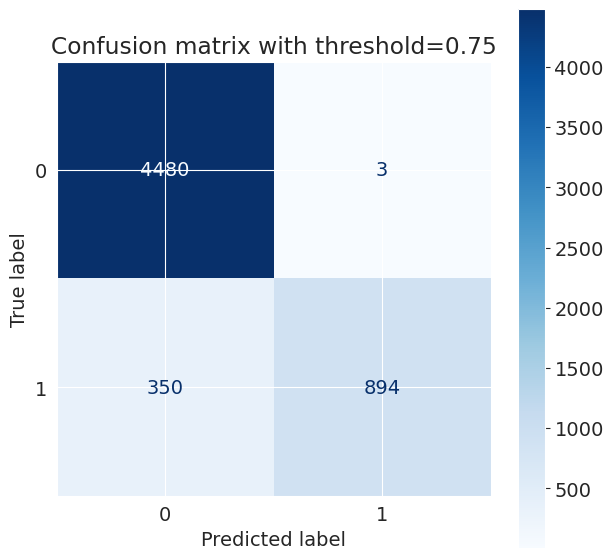

In [105]:
plot_conf_mat(final_xgboost, # The classifier object
              x_test, # The test data set aside for evaluation in train_test_split
              y_test # Actual labels
             )

In [106]:
FP_Cost = (3 * 2800) * (28631/5727) #Extrapolate on total
FN_Cost = (350 * 13500) * (28539/5812) #Extrapolate on total

print("Total Cost = ${:.2f}".format(FP_Cost + FN_Cost))

Total Cost = $23243435.12


In [107]:
Scenario_1_3 = 83727000 - 23243435.12
print("Savings compared to scenario 1: ${:.2f}".format(Scenario_1_3))

Savings compared to scenario 1: $60483564.88


In [108]:
Scenario_2_3 = 62801200 - 23243435.12
print("Savings compared to scenario 2: ${:.2f}".format(Scenario_2_3))

Savings compared to scenario 2: $39557764.88


Not great, we ended up costing more money than the default threshold of 0.5

#### Let's see if we can make more improvements by lowering the threshold

Now we will try lowering the threshold to .25

In [109]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.25):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

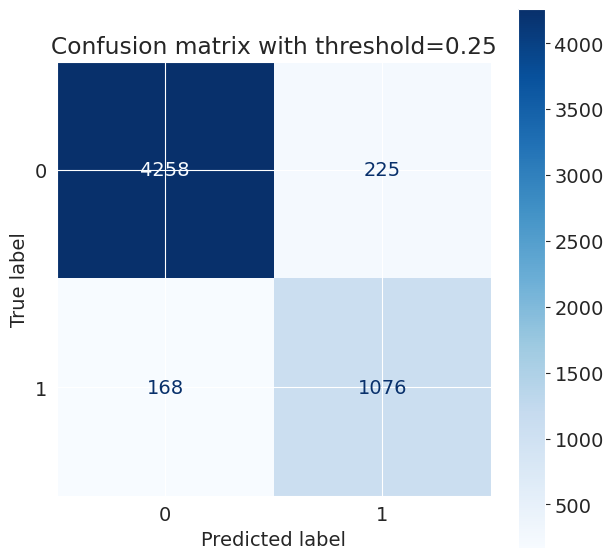

In [110]:
plot_conf_mat(final_xgboost, # The classifier object
              x_test, # The test data set aside for evaluation in train_test_split
              y_test # Actual labels
             )

In [111]:
FP_Cost = (225 * 2800) * (28631/5727) #Extrapolate on total
FN_Cost = (168 * 13500) * (28539/5812) #Extrapolate on total

print("Total Cost = ${:.2f}".format(FP_Cost + FN_Cost))

Total Cost = $14286251.65


In [112]:
Scenario_1_3 = 83727000 - 14286251.65
print("Savings compared to scenario 1: ${:.2f}".format(Scenario_1_3))

Savings compared to scenario 1: $69440748.35


In [113]:
Scenario_2_3 = 62801200 - 14286251.65
print("Savings compared to scenario 2: ${:.2f}".format(Scenario_2_3))

Savings compared to scenario 2: $48514948.35


This approach is a significant improvement, and while further optimization is always possible, it provides a solid foundation for managing financial risks. By fine-tuning the decision threshold, the bank can dynamically adjust its model depending on the **economic conditions** and **market trends**. As conditions change — for example, in times of economic downturn when loan defaults may increase — the bank can adjust the threshold to be more cautious, minimizing **false negatives** and protecting against potential losses. Conversely, in more stable or growth periods, the bank could adjust the threshold to minimize **false positives**, avoiding unnecessary loan rejections and capturing profitable opportunities. This level of flexibility ensures that the bank remains adaptable and can maximize profitability while managing risk effectively.